# ACTIVIDAD : Redes Convolucionales

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes los Simpsons.

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de la serie extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/)
Partiendo de los 18 personajes etiquetados, éstos pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [17]:
## Librerías utilizadas
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import cv2
import os
import numpy as np
import os
import torch
# import keras
# from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import kagglehub
import shutil
import random
from sklearn.model_selection import train_test_split

Nos descargamos la carpeta de la web de Kaggle:
https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset?resource=download&select=simpsons_dataset

In [18]:
## Descargar dataset
path = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")
print("Descargado en:", path)

## Definir rutas
source_path = os.path.join(path, "simpsons_dataset")
target_path = "./simpsons_dataset"

## Si ya existe, eliminar y copiar de nuevo
if os.path.exists(target_path):
    shutil.rmtree(target_path)
    print(f"⚠️ Carpeta existente eliminada: {target_path}")

shutil.copytree(source_path, target_path)
print(f"✅ Dataset copiado a: {target_path}")

Descargado en: C:\Users\sergi.zarzuelo.abel1\.cache\kagglehub\datasets\alexattia\the-simpsons-characters-dataset\versions\4
✅ Dataset copiado a: ./simpsons_dataset


Podemos ver que los personajes están repartidos en carpetas

In [19]:
# ## Los personajes se encuentran en carpetas
# !ls $path/simpsons_dataset


In [20]:
dataset_dir = target_path
conteo_imagenes = {}

for cls in sorted(os.listdir(dataset_dir)):
    cls_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(cls_path):
        imagenes = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]
        conteo_imagenes[cls] = len(imagenes)

## Mostrar resultados ordenados
for cls, count in sorted(conteo_imagenes.items(), key=lambda x: x[1]):
    print(f"{cls:30s} -> {count} imágenes")

lionel_hutz                    -> 3 imágenes
disco_stu                      -> 8 imágenes
troy_mcclure                   -> 8 imágenes
miss_hoover                    -> 17 imágenes
fat_tony                       -> 27 imágenes
gil                            -> 27 imágenes
otto_mann                      -> 32 imágenes
sideshow_mel                   -> 40 imágenes
agnes_skinner                  -> 42 imágenes
rainier_wolfcastle             -> 45 imágenes
cletus_spuckler                -> 47 imágenes
snake_jailbird                 -> 55 imágenes
professor_john_frink           -> 65 imágenes
martin_prince                  -> 71 imágenes
patty_bouvier                  -> 72 imágenes
ralph_wiggum                   -> 89 imágenes
carl_carlson                   -> 98 imágenes
selma_bouvier                  -> 103 imágenes
barney_gumble                  -> 106 imágenes
groundskeeper_willie           -> 121 imágenes
maggie_simpson                 -> 128 imágenes
waylon_smithers                ->

Como Lionel solo tiene tres imágenes, lo quitamos del entrenamiento

In [21]:
# !rm -r ./simpsons_dataset/lionel_hutz

In [22]:
import shutil

shutil.rmtree("./simpsons_dataset/lionel_hutz")

Ahora generaremos diferentes carpetas separando los datos de train, test y validación

In [23]:
## Definimos los paths
ORIGINAL_DATASET_DIR = './simpsons_dataset'
BASE_OUTPUT_DIR = './simpsons_split_dataset'

## Porcentajes; he optado por generar sets de train, test y validación.
## Pero podéis variar los porcentajes
train_pct = 0.7
val_pct = 0.15
test_pct = 0.15

## Crear estructura de carpetas
splits = ['train', 'val', 'test']
classes = os.listdir(ORIGINAL_DATASET_DIR)
classes = [cls for cls in classes if os.path.isdir(os.path.join(ORIGINAL_DATASET_DIR, cls))]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(BASE_OUTPUT_DIR, split, cls), exist_ok=True)

## Dividir y copiar imágenes
for cls in classes:
    cls_path = os.path.join(ORIGINAL_DATASET_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]
    random.shuffle(images)

    # Asignación predeterminada
    train, val, test = [], [], []

    if len(images) >= 3:
        train, temp = train_test_split(images, train_size=train_pct, random_state=42)
        val, test = train_test_split(temp, test_size=test_pct / (test_pct + val_pct), random_state=42)
    else:
        # Si hay muy pocas imágenes, lo mandamos todo al entrenamiento
        train = images
        print(f"[Aviso] Clase '{cls}' tiene muy pocas imágenes ({len(images)}). Se asignan todas a entrenamiento.")

    for img_list, split in zip([train, val, test], ['train', 'val', 'test']):
        for img in img_list:
            src = os.path.join(cls_path, img)
            dst = os.path.join(BASE_OUTPUT_DIR, split, cls, img)
            shutil.copyfile(src, dst)

In [24]:
## Crear diccionario de mapeo automáticamente
MAP_CHARACTERS = {i: cls for i, cls in enumerate(sorted(classes))}
MAP_CHARACTERS

{0: 'abraham_grampa_simpson',
 1: 'agnes_skinner',
 2: 'apu_nahasapeemapetilon',
 3: 'barney_gumble',
 4: 'bart_simpson',
 5: 'carl_carlson',
 6: 'charles_montgomery_burns',
 7: 'chief_wiggum',
 8: 'cletus_spuckler',
 9: 'comic_book_guy',
 10: 'disco_stu',
 11: 'edna_krabappel',
 12: 'fat_tony',
 13: 'gil',
 14: 'groundskeeper_willie',
 15: 'homer_simpson',
 16: 'kent_brockman',
 17: 'krusty_the_clown',
 18: 'lenny_leonard',
 19: 'lisa_simpson',
 20: 'maggie_simpson',
 21: 'marge_simpson',
 22: 'martin_prince',
 23: 'mayor_quimby',
 24: 'milhouse_van_houten',
 25: 'miss_hoover',
 26: 'moe_szyslak',
 27: 'ned_flanders',
 28: 'nelson_muntz',
 29: 'otto_mann',
 30: 'patty_bouvier',
 31: 'principal_skinner',
 32: 'professor_john_frink',
 33: 'rainier_wolfcastle',
 34: 'ralph_wiggum',
 35: 'selma_bouvier',
 36: 'sideshow_bob',
 37: 'sideshow_mel',
 38: 'snake_jailbird',
 39: 'troy_mcclure',
 40: 'waylon_smithers'}

## Ejercicio

Utilizando Convolutional Neural Networks, entrenar al menos dos clasificadores que sean capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **90%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos, pero cuánta más información podáis aportar mejor a la hora de desarrollar vuestro modelo):

*   Análisis de los datos a utilizar. ¿Qué distribución siguen? ¿Están las clases balanceadas?
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected (sin convolución) para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.


Notas:
* Los datos están en una única carpeta, por lo que tendrás que hacer el split entre train y test
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo de al menos los dos mejores modelos obtenidos y la evaluación de los datos de test con estos modelos**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más sencillas de identificar, por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Modelo 1 (CNN simple)

## Preparacion de los datos

En esta sección se va a desarrollar un modelo CNN simple. Aunque Keras o TensorFlow pueden ser mas amigables a la hora de programar un modelo, este será desarrollado en PyTorch dado que es más complicado (estamos para aprender) y más utilizado en casos reales.

In [72]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

Se especifican las rutas de las carpetas creadas para el train, test y validation

In [73]:
# 📍 Rutas a tus carpetas
train_dir = "./simpsons_split_dataset/train"
val_dir = "./simpsons_split_dataset/val"
test_dir = "./simpsons_split_dataset/test"

Se especifican ajustes (transformaciones) que se quieren realizar una vez se carguen los datasets:

- Resize (Necesario): Redimensiona todas las imágenes a 64×64 píxeles (Las CNNs requieren que todas las imágenes tengan el mismo tamaño, de esta manera se asegura)
- ToTensor (Necesario): Convierte la imagen PIL o NumPy en un tensor PyTorch de forma (C, H, W) y normaliza a [0, 1]
- Normalize (Opcional): Normaliza los valores de cada canal de la imagen (Practica comun para que todo funcione mejor). Como viene despues de ToTensor cambia [0,1] a [-1,1]

In [74]:
# 🔄 Transformaciones
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Redimensiona todas las imágenes a 64x64 píxeles.
    transforms.ToTensor(),                # Convierte la imagen en un tensor PyTorch y normaliza a [0, 1].
    transforms.Normalize([0.5], [0.5])    # Normaliza los valores de cada canal a un rango de [-1, 1].
])

Se cargan los datasets, con las rutas especificadas y con los ajustes o transformaciones definidas. Cada dataset tendra elementos de la forma (img_tensor, etiqueta), donde img_tensor es un tensor de 3 dimensiones con forma (C, H, W):

- C: número de canales (3 para RGB)
- H: altura de la imagen (por ejemplo, 64)
- W: ancho de la imagen (por ejemplo, 64)

In [75]:
# 📂 Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

# 🧾 Clases
print("Clases detectadas:", train_dataset.classes) # para comprobar que se han cargado correctamente

Clases detectadas: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


Por entender mejor la estructura de los datos, vamos a ver un ejemplo en detalle. Si hacemos:

img_tensor, etiqueta = train_dataset[0]

tenemos img_tensor un tensor 3D de dimensiones (3, 64, 64) y una etiqueta por ejemplo 0 que representa "abraham_grampa_simpson". En otras palabras:

- img_tensor[0]: matriz (64,64) con información del canal rojo
- img_tensor[1]: matriz (64,64) con información del canal verde
- img_tensor[2]: matriz (64,64) con información del canal azul

Que al combinarlos se genera el tensor (3, 64, 64)

Tamaño tensor: torch.Size([3, 64, 64])
Etiqueta: 0
Visualizacion numerica de ejemplo del canal rojo:
 tensor([[-0.2863, -0.2549, -0.2627,  ...,  0.1059,  0.0980,  0.0980],
        [-0.2863, -0.2549, -0.2627,  ...,  0.1059,  0.0980,  0.0980],
        [-0.3020, -0.2706, -0.2706,  ...,  0.0980,  0.0980,  0.1137],
        ...,
        [ 0.4275,  0.4667,  0.3804,  ...,  0.6392,  0.5216,  0.1059],
        [ 0.3647,  0.4588,  0.3020,  ...,  0.6784,  0.4745,  0.0980],
        [-0.0667,  0.3725,  0.3020,  ...,  0.6863,  0.5294,  0.0039]])


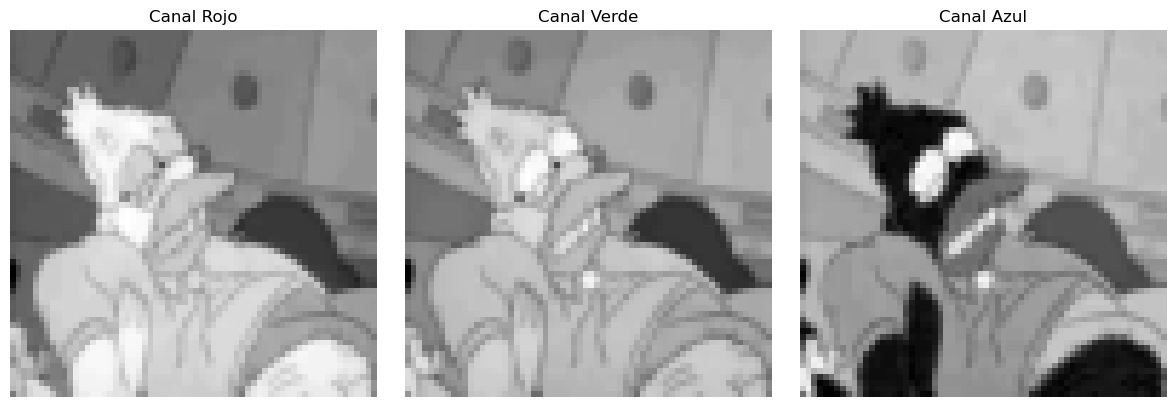

In [76]:
img_tensor, etiqueta = train_dataset[0]

print("Tamaño tensor:", img_tensor.size())
print("Etiqueta:", etiqueta)

print("Visualizacion numerica de ejemplo del canal rojo:\n", img_tensor[0])

# Visuaización de los canales
# Crear una figura con 3 subplots en una fila
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Canal rojo
axs[0].imshow(img_tensor[0], cmap='gray')
axs[0].set_title("Canal Rojo")
axs[0].axis('off')

# Canal verde
axs[1].imshow(img_tensor[1], cmap='gray')
axs[1].set_title("Canal Verde")
axs[1].axis('off')

# Canal azul
axs[2].imshow(img_tensor[2], cmap='gray')
axs[2].set_title("Canal Azul")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Teniendo ya cargados los datasets, hacer uso de ellos tal cual no es muy eficiente ya que habria que ir accediendo a las imagenes una por una. Por ello, existe un ultimo paso en la carga de la informacion que es utilizar DataLoader, donde se generan bloques o batch de imagenes como unidad durante el entrenamiento del modelo. Esto hace que todo el proceso sea mucho más rápido y ordenado.

In [77]:
# 🧳 DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Se barajan los datos en cada época para evitar sobreajuste
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False) 
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Una vez generados los batches, visualizamos uno de ejemplo.

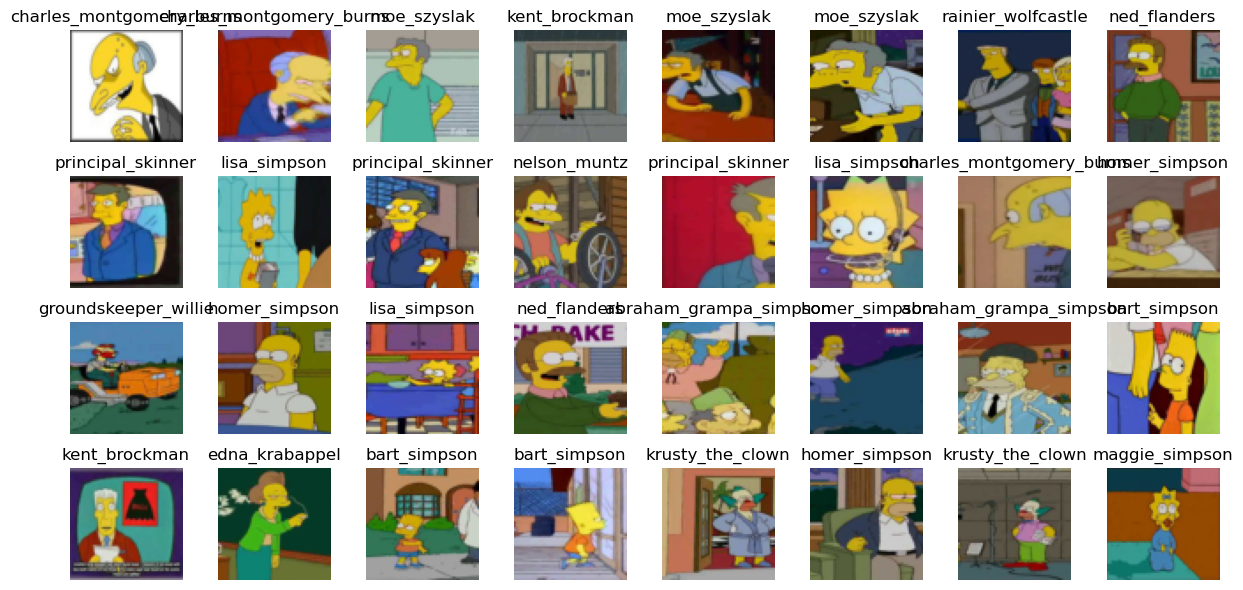

In [78]:
# Visualización de imágenes
def show_batch(loader, dataset):
    images, labels = next(iter(loader))                         # Obtiene un batch de imágenes y etiquetas del DataLoader.
    fig, ax = plt.subplots(4, 8, figsize=(12, 6))               # Crea una figura con una cuadrícula de 4 filas y 8 columnas para mostrar 32 imágenes.
    for i in range(32):                                         # Itera sobre las primeras 32 imágenes del batch.
        img = images[i].permute(1, 2, 0) * 0.5 + 0.5            # Cambia el orden de los ejes del tensor (C, H, W → H, W, C) y desnormaliza los valores.
        ax[i//8, i%8].imshow(img)                               # Muestra la imagen en la posición correspondiente de la cuadrícula.
        ax[i//8, i%8].axis('off')                               # Oculta los ejes de la imagen.
        ax[i//8, i%8].set_title(dataset.classes[labels[i]])     # Establece el título con el nombre de la clase correspondiente a la etiqueta.
    plt.tight_layout()                                          # Ajusta el espaciado entre subgráficos para evitar superposiciones.
    plt.show()                                                  # Muestra la figura con las imágenes.

# Visualiza un batch de entrenamiento
show_batch(train_loader, train_dataset)

## Entrenamiento

En primer lugar se mira si existe disponible GPU puesto que es mas eficiente para modelos de CNN. En caso contrario, se usara el CPU:

In [79]:
# 📦 Usa GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cpu


Se va a desarrollar una CNN basica, con dos partes:

1. `self.conv_layer` → Está compuesto por **6 capas en total**, organizadas en **2 bloques**:

    - **Conv2D**: capas convolucionales que extraen patrones visuales como bordes, colores o texturas. La primera convierte de 3 canales (RGB) a 32 mapas de características, y la segunda de 32 a 64.
    
    - **ReLU**: funciones de activación no lineales que permiten a la red aprender relaciones complejas, manteniendo los valores positivos y anulando los negativos.
    
    - **MaxPool2D**: capas de reducción espacial (pooling) que disminuyen el tamaño de las imágenes a la mitad en cada bloque, lo que reduce el coste computacional y mantiene las características más relevantes.

    En conjunto, estos bloques procesan una imagen de entrada de tamaño `(3, 64, 64)` y la transforman en un tensor de tamaño `(64, 16, 16)` al final de esta sección.


2. `self.fc_layer` → Está compuesto por **4 capas secuenciales**, encargadas de realizar la clasificación final a partir de las características extraídas por las convoluciones:

   - **Flatten**: aplana el tensor de salida de tamaño `(64, 16, 16)` proveniente del bloque convolucional, convirtiéndolo en un vector de 16.384 elementos para poder conectarlo a las capas lineales.
   
   - **Linear1 (Fully connected)**: la primera capa totalmente conectada reduce los 16.384 valores a 128 neuronas intermedias. 
   
   - **ReLU**: función de activación aplicada entre las dos capas lineales, que introduce no linealidad y permite a la red aprender relaciones más complejas.

   - **Linear2 (Fully connected)**: la segunda capa toma esos 128 valores y los transforma en tantas salidas como clases haya en el problema (`num_classes`).

   En conjunto, este bloque toma la información extraída por las convoluciones y la traduce en una predicción final de clase.



In [80]:
#  Modelo CNN simple
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        """
        Inicializa la red convolucional simple.
        
        :param num_classes: Número de clases de salida (10 en este caso).
        """
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # Toma 3 canales de entrada (RGB), aplica 32 filtros de convolución de tamaño 3x3, y padding de 1 para mantener el tamaño de la imagen.
            nn.ReLU(),                                      # Modifica el valor de cada celda: Si x < 0, entonces f(x) = 0. Si x >= 0, entonces f(x) = x.
            nn.MaxPool2d(2),                                # Reduce las dimensiones de la imagen a la mitad (de 64x64 → 32x32) mediante max pooling con kernel 2x2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # Toma 32 canales de entrada (del bloque anterior), aplica 64 filtros de convolución de tamaño 3x3, y padding de 1 para mantener el tamaño de la imagen.
            nn.ReLU(),                                      # Modifica el valor de cada celda: Si x < 0, entonces f(x) = 0. Si x >= 0, entonces f(x) = x.
            nn.MaxPool2d(2),                                # Reduce las dimensiones de la imagen a la mitad (de 32x32 → 16x16) mediante max pooling con kernel 2x2
        )

        # Output: (64, 16, 16) (64 canales de salida, cada uno de tamaño 16x16)

        self.fc_layer = nn.Sequential(

            nn.Flatten(),                                   # Aplana el tensor de salida de la parte convolucional (64, 16, 16) en un vector de tamaño 64*16*16 para poder pasarlo a capas lineales.
            nn.Linear(64 * 16 * 16, 128),                   # Capa totalmente conectada que reduce el vector de entrada (16.384 elementos) a 128 neuronas intermedias.
            nn.ReLU(),                                      # Activación no lineal que permite a la red aprender relaciones complejas.
            nn.Linear(128, num_classes)                     # Capa de salida que mapea las 128 neuronas a tantas salidas como clases tenga el problema (una por clase).

        )

        # Output: Un vector 1D con 10 valores (uno por clase) que representa la probabilidad de que la imagen pertenezca a cada clase.

    def forward(self, x): 
        """
        Método de propagación hacia adelante. Define cómo se transforma la entrada a través de la red.

        :param x: Tensor de entrada (batch de imágenes).
        :return: Tensor de salida (predicciones de clase).
        """
        x = self.conv_layer(x)                              # Pasa la entrada a través de las capas convolucionales y de pooling.   
        x = self.fc_layer(x)                                # Pasa la salida a través de las capas totalmente conectadas.    
        return x                                            # Devuelve la salida final de la red.
    

A continuación se hace la `instanciación del modelo`

In [81]:
num_classes = len(train_dataset.classes)                # Determina cuántas categorías debe predecir el modelo.
model_1 = SimpleCNN(num_classes).to(device)             # Se crea y se envía al dispositivo (GPU/CPU)

# Esto último esta pensado para que el modelo pueda ser ejecutado en GPU si está disponible, lo que acelerará el entrenamiento y la inferencia. 
# Si no hay GPU, el modelo se ejecutará en la CPU, pero se deja programado de esta manera para que sea más eficiente en caso de que el hardware lo permita.

Se determina cuales van a ser la `funcion de perdida` y el `optimizador`

In [95]:
criterion_1 = nn.CrossEntropyLoss()                       # Función de pérdida que combina softmax y cross-entropy en una sola función. Ideal para clasificación multiclase.
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)    # Optimizador Adam, que es una mejora del SGD. Se adapta automáticamente a cada parámetro y tiene un buen rendimiento en la mayoría de los casos.

Por último, se define la `función de entrenamiento`. 

*Reminder*: En `model_1` tenemos asignado nuestro modelo SimpleCNN

In [96]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    # Bucle principal de entrenamiento por cada época
    for epoch in range(epochs):                         # En cada epoch se recorre todo el dataset de entrenamiento
        model.train()                                   # Activa modo entrenamiento (habilita dropout, batchnorm, etc.)
        running_loss = 0.0                              # Inicializacion variable para acumular la pérdida total (loss) de cada batch a lo largo de toda la época actual
        correct = 0                                     # Inicializacion variable para acumular predicciones correctas en cada batch a lo largo de toda la época actual
        total = 0                                       # Inicializacion variable para contar el número total de ejemplos procesados durante toda la época.

        # Bucle sobre todos los batches del conjunto de entrenamiento (que esta en formato DataLoader))
        for images, labels in tqdm(train_loader, desc=f"Época {epoch+1}/{epochs}"):     

            images, labels = images.to(device), labels.to(device)  # Como antes hemos movido el modelo a device (CPU o GPU), se mueven los datos (imágenes y etiquetas) también
                        
            optimizer.zero_grad()                       # Se quiere un gradiente por cada batch. Se reinicia gradiente para no acumular el del batch anterior
            outputs = model(images)                     # Se obtiene la predicción del modelo para el batch actual de imágenes
            loss = criterion(outputs, labels)           # Calcula la pérdida entre predicción y etiqueta real (-log(probabilidad de la clase correcta))
            loss.backward()                             # Backpropagation: se calculan los gradientes de la función de pérdida respecto a los parámetros del modelo (regla de la cadena)
            optimizer.step()                            # Gradient descent: toma los gradientes de loss.backward() y actualiza los pesos del modelo para minimizar la pérdida

# Esta última parte se entiende como:
#   - Forward pass (outputs) → el modelo intenta una predicción.
#   - Cálculo de pérdida → mide qué tan mal lo hizo.
#   - Backward pass (loss.backward()) → calcula cómo corregir los pesos para mejorar (Backpropragation).
#   - Optimizer step → realiza el cambio real en los pesos.

            running_loss += loss.item()                 # Acumula la pérdida por batch para tener un loss final por época
            _, preds = torch.max(outputs, 1)            # Obtiene la clase con mayor probabilidad (predicción)
            correct += (preds == labels).sum().item()   # Acumula el número de cuántas predicciones fueron correctas por batch para tener un total de aciertos por época
            total += labels.size(0)                     # Suma la cantidad total de ejemplos

        # Calcula y muestra la accuracy en entrenamiento para la época actual
        acc = 100 * correct / total
        print(f"\n✅ Entrenamiento — Loss: {running_loss:.4f} | Accuracy: {acc:.2f}%")


        # --- Validación ---

        model.eval()                                    # Activa modo evaluación (desactiva dropout, etc.)
        val_correct = 0                                 # Inicializacion variable para contar predicciones correctas en validación  
        val_total = 0                                   # Inicializacion variable para contar total de ejemplos procesados en validación

        # No se calculan gradientes durante validación (ahorra memoria)
        with torch.no_grad():

            # Se repiten los pasos de la validación para cada batch del conjunto de validación (que esta en formato DataLoader))
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)         
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Calcula y muestra la accuracy en validación
        val_acc = 100 * val_correct / val_total
        print(f"🔍 Validación — Accuracy: {val_acc:.2f}%\n")

    return model  # Devuelve el modelo ya entrenado


In [84]:
from sklearn.metrics import classification_report, accuracy_score

def test_model(model, test_loader, class_names):    # Procedimiento basicamente identico al de validación
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Accuracy total en test: {acc * 100:.2f}%")

    return classification_report(all_labels, all_preds, target_names=class_names, output_dict=True) # En validación no se imprime por eficiencia, pero en test sí (ya hay un modelo final) 

In [ ]:
# Entrena el modelo
modelo_entrenado_1 = train_model(model_1, train_loader, val_loader, criterion_1, optimizer_1, epochs=1)

Época 1/1: 100%|██████████| 458/458 [02:38<00:00,  2.90it/s]



✅ Entrenamiento — Loss: 933.7017 | Accuracy: 45.16%
🔍 Validación — Accuracy: 59.87%



In [86]:
# Evalúa en test
metricas_test_1 = test_model(modelo_entrenado_1, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

✅ Accuracy total en test: 59.16%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
marge_simpson              0.690083  0.860825  0.766055    194.0
kent_brockman              0.760563  0.720000  0.739726     75.0
krusty_the_clown           0.593985  0.872928  0.706935    181.0
sideshow_bob               0.770642  0.636364  0.697095    132.0
edna_krabappel             0.680556  0.710145  0.695035     69.0
chief_wiggum               0.566964  0.858108  0.682796    148.0
apu_nahasapeemapetilon     0.610169  0.765957  0.679245     94.0
milhouse_van_houten        0.618557  0.740741  0.674157    162.0
homer_simpson              0.643275  0.652819  0.648012    337.0
ned_flanders               0.528662  0.757991  0.622889    219.0
abraham_grampa_simpson     0.802326  0.503650  0.618834    137.0
moe_szyslak                0.631068  0.596330  0.613208    218.0
principal_skinner          0.633540  0.566667  0.598240    180.0
co

c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

Como puede observarse, las clases con peores resultados son aquellas con muy poca materialidad. De hecho, el propio código nos arroja un warning advirtiendo que la precision se esta seteando a 0 debido a el modelo no ha predicho ni una sola muestra de alguna clase. Es decir, el modelo nunca elige algunas clases como predicción.

En el siguiente modelo, se tratará de ajustar esta debilidad debida al desbalanceo de clases mediante el uso de Data Augmentation.

# Modelo 1 (CNN simple) + Data Augmentation

## Ajustes respecto el modelo previo

Para este modelo, ademas de las transformaciones del modelo anterior se incluyen dos adicionales de Data augmentation:

- RandomHorizontalFlip (Opcional): Invierte horizontalmente imágenes aleatoriamente (Data augmnetation). Solo durante entrenamiento.
- RandomRotation (Opcional): Rota aleatoriamente las imagenes hasta un maximo de grados indicados (Data augmentation). Solo durante entrenamiento

Estos ajustes solamente van a cambiar la muestra de entrenamiento, puesto que el data augmentation no se debe aplicar a las muestras de test y val.

In [ ]:
# 🔄 Transformaciones
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),          # Redimensiona todas las imágenes a 64x64 píxeles.
    transforms.RandomHorizontalFlip(),    # Invierte horizontalmente imágenes aleatoriamente (data augmentation).
    transforms.RandomRotation(15),        # Rota las imágenes aleatoriamente hasta ±15 grados (data augmentation).
    transforms.ToTensor(),                # Convierte la imagen en un tensor PyTorch y normaliza a [0, 1].
    transforms.Normalize([0.5], [0.5])    # Normaliza los valores de cada canal a un rango de [-1, 1].
])

# 📂 Datasets
train_dataset_aug = datasets.ImageFolder(train_dir, transform=transform_train)

# 🧳 DataLoaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True) # Se barajan los datos en cada época para evitar sobreajuste

Clases detectadas: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


## Entrenamiento

El modelo es exactamente igual al anterior, solo que el dataset de entrada con el que se entrena ha sido ajustado.

In [ ]:
# Entrena el modelo
modelo_entrenado_1_aug = train_model(model_1, train_loader_aug, val_loader, criterion_1, optimizer_1, epochs=1)

Época 1/1: 100%|██████████| 458/458 [02:59<00:00,  2.55it/s]



✅ Entrenamiento — Loss: 632.6487 | Accuracy: 62.21%
🔍 Validación — Accuracy: 64.75%



In [90]:
# Evalúa en test
metricas_test_1_aug = test_model(modelo_entrenado_1_aug, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1_aug).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

✅ Accuracy total en test: 65.21%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
marge_simpson              0.805687  0.876289  0.839506    194.0
krusty_the_clown           0.833333  0.828729  0.831025    181.0
chief_wiggum               0.776316  0.797297  0.786667    148.0
milhouse_van_houten        0.779141  0.783951  0.781538    162.0
edna_krabappel             0.830508  0.710145  0.765625     69.0
kent_brockman              0.777778  0.746667  0.761905     75.0
sideshow_bob               0.850467  0.689394  0.761506    132.0
apu_nahasapeemapetilon     0.747253  0.723404  0.735135     94.0
ned_flanders               0.761194  0.698630  0.728571    219.0
selma_bouvier              0.833333  0.625000  0.714286     16.0
abraham_grampa_simpson     0.740157  0.686131  0.712121    137.0
principal_skinner          0.791667  0.633333  0.703704    180.0
comic_book_guy             0.734375  0.661972  0.696296     71.0
ho

c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

In [ ]:
# Entrena el modelo
modelo_entrenado_1_aug = train_model(model_1, train_loader_aug, val_loader, criterion_1, optimizer_1, epochs=1)

Época 1/1: 100%|██████████| 458/458 [02:59<00:00,  2.55it/s]



✅ Entrenamiento — Loss: 632.6487 | Accuracy: 62.21%
🔍 Validación — Accuracy: 64.75%



In [ ]:
# Evalúa en test
metricas_test_1_aug = test_model(modelo_entrenado_1_aug, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1_aug).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

✅ Accuracy total en test: 65.21%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
marge_simpson              0.805687  0.876289  0.839506    194.0
krusty_the_clown           0.833333  0.828729  0.831025    181.0
chief_wiggum               0.776316  0.797297  0.786667    148.0
milhouse_van_houten        0.779141  0.783951  0.781538    162.0
edna_krabappel             0.830508  0.710145  0.765625     69.0
kent_brockman              0.777778  0.746667  0.761905     75.0
sideshow_bob               0.850467  0.689394  0.761506    132.0
apu_nahasapeemapetilon     0.747253  0.723404  0.735135     94.0
ned_flanders               0.761194  0.698630  0.728571    219.0
selma_bouvier              0.833333  0.625000  0.714286     16.0
abraham_grampa_simpson     0.740157  0.686131  0.712121    137.0
principal_skinner          0.791667  0.633333  0.703704    180.0
comic_book_guy             0.734375  0.661972  0.696296     71.0
ho

c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

# Modelo 1 (CNN simple) + Data Augmentation + Balanced

## Ajustes respecto el modelo previo

Para este modelo, ademas del Data augmentation, se incluirá un ajuste en el criterio de pérdida para balancear el peso de las clase minoritarias, dandoles un mayor peso en el entrenamiento del modelo.

In [99]:
from sklearn.utils.class_weight import compute_class_weight

# Paso 1: Obtener los targets (etiquetas) del dataset
labels = train_dataset.targets  # Asegúrate de que esto devuelva una lista o array de ints

# Paso 2: Calcular pesos por clase
import numpy as np
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=np.array(labels))

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Paso 3: Crear la función de pérdida ponderada
criterion_1_bal = nn.CrossEntropyLoss(weight=class_weights)

## Entrenamiento

El modelo es exactamente igual al anterior, solo que cambia el criterio de perdida.

In [100]:
# Entrena el modelo
modelo_entrenado_1_aug_bal = train_model(model_1, train_loader_aug, val_loader, criterion_1_bal, optimizer_1, epochs=1)

Época 1/1: 100%|██████████| 458/458 [02:53<00:00,  2.64it/s]



✅ Entrenamiento — Loss: 740.9433 | Accuracy: 61.45%
🔍 Validación — Accuracy: 60.86%



In [101]:
# Evalúa en test
metricas_test_1_aug_bal = test_model(modelo_entrenado_1_aug_bal, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_1_aug_bal).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

✅ Accuracy total en test: 61.29%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
krusty_the_clown           0.891720  0.773481  0.828402    181.0
kent_brockman              0.783133  0.866667  0.822785     75.0
marge_simpson              0.900000  0.742268  0.813559    194.0
milhouse_van_houten        0.918033  0.691358  0.788732    162.0
chief_wiggum               0.787671  0.777027  0.782313    148.0
edna_krabappel             0.886792  0.681159  0.770492     69.0
apu_nahasapeemapetilon     0.809524  0.723404  0.764045     94.0
carl_carlson               0.650000  0.866667  0.742857     15.0
sideshow_bob               0.868132  0.598485  0.708520    132.0
homer_simpson              0.737013  0.673591  0.703876    337.0
principal_skinner          0.807407  0.605556  0.692063    180.0
ned_flanders               0.769663  0.625571  0.690176    219.0
abraham_grampa_simpson     0.668966  0.708029  0.687943    137.0
se

c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

Se puede ver que las clases minoritarias obtienen resultados mejores que con los modelos previos gracias al ajuste en el criterio de loss, que le da un mayor peso a estas clases.

# Modelo 2 (CNN avanzado) + Data Augmentation + Balanced

## Entrenamiento

Se va a desarrollar una CNN más profunda y robusta que las CNN vistas anteriormente, con una arquitectura basada en dos partes principales:

1. `self.features` → Está compuesto por **9 capas en total**, organizadas en **3 bloques convolucionales**:

   - **Conv2D**: capas convolucionales que extraen patrones visuales. La primera convierte de 3 canales (RGB) a 32 mapas de características, la segunda de 32 a 64, y la tercera de 64 a 128. Todas usan filtros 3x3 con padding para mantener las dimensiones espaciales.
   
   - **BatchNorm2D**: normalización por lotes que estabiliza y acelera el entrenamiento al reducir la variación interna de las activaciones. Se aplica tras las dos primeras convoluciones.
   
   - **ReLU**: funciones de activación que mantienen los valores positivos y anulan los negativos, introduciendo no linealidad al modelo.
   
   - **MaxPool2D**: reducción espacial que disminuye el tamaño de las imágenes a la mitad después de los dos primeros bloques, conservando las características más importantes.
   
   - **AdaptiveAvgPool2D**: reduce cada mapa de activación de tamaño variable a un tamaño fijo de `(4, 4)`, permitiendo que la arquitectura sea más flexible ante distintas resoluciones de entrada.

   En conjunto, estos bloques procesan una imagen de entrada de tamaño `(3, 64, 64)` y la transforman en un tensor de tamaño fijo `(128, 4, 4)` al final de esta sección.

2. `self.classifier` → Está compuesto por **5 capas secuenciales**, encargadas de realizar la clasificación final a partir de las características extraídas:

   - **Flatten**: aplana el tensor de salida `(128, 4, 4)` en un vector de 2048 elementos para poder conectarlo con capas densas.
   
   - **Linear1 (Fully connected)**: reduce los 2048 valores a 256 neuronas intermedias, condensando la información.
   
   - **ReLU**: añade no linealidad entre capas densas para mejorar la capacidad de aprendizaje.
   
   - **Dropout**: desactiva aleatoriamente el 50% de las neuronas durante el entrenamiento, reduciendo el riesgo de sobreajuste.
   
   - **Linear2 (Fully connected)**: transforma las 256 activaciones en `num_classes` salidas, correspondientes a las clases del problema.

   Este bloque toma la representación profunda obtenida por las convoluciones y la convierte en una predicción final de clase.

---

Este modelo es más potente que `SimpleCNN` ya que incorpora mayor profundidad, normalización, regularización y una mejor adaptación al tamaño de entrada, lo cual mejora su rendimiento en datasets complejos o desbalanceados.

In [103]:
#  Modelo CNN más profundo con batch normalization, dropout y adaptive pooling
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        """
        Inicializa una red convolucional más profunda que la SimpleCNN.
        
        :param num_classes: Número de clases de salida.
        """
        super().__init__()

        self.features = nn.Sequential(

            nn.Conv2d(3, 32, 3, padding=1),              # Primer bloque: 3 canales RGB → 32 mapas de características (filtros 3x3, padding 1 mantiene tamaño: 64x64).
            nn.BatchNorm2d(32),                          # Normaliza las activaciones para estabilizar y acelerar el entrenamiento.
            nn.ReLU(),                                   # Función de activación ReLU para introducir no linealidad.
            nn.MaxPool2d(2),                             # Reduce las dimensiones espaciales a la mitad (64x64 → 32x32).

            nn.Conv2d(32, 64, 3, padding=1),             # Segundo bloque: 32 canales de entrada → 64 filtros 3x3 (tamaño permanece: 32x32).
            nn.BatchNorm2d(64),                          # Batch normalization sobre los 64 mapas de características.
            nn.ReLU(),                                   # Activación no lineal.
            nn.MaxPool2d(2),                             # Reduce tamaño a la mitad nuevamente (32x32 → 16x16).

            nn.Conv2d(64, 128, 3, padding=1),            # Tercer bloque: 64 → 128 filtros, mantiene dimensiones: 16x16.
            nn.ReLU(),                                   # Activación ReLU (sin batch norm esta vez).
            nn.AdaptiveAvgPool2d((4, 4))                 # Reduce dinámicamente cada mapa a tamaño fijo 4x4 (sin importar el tamaño de entrada exacto).
        )

        # Output de features: (128, 4, 4) → 128 canales de salida, cada uno de 4x4

        self.classifier = nn.Sequential(

            nn.Flatten(),                                # Aplana los tensores 128x4x4 en un vector de tamaño 2048 (128 * 4 * 4).
            nn.Linear(128 * 4 * 4, 256),                 # Capa totalmente conectada de 2048 → 256 neuronas.
            nn.ReLU(),                                   # Activación no lineal.
            nn.Dropout(0.5),                             # Desactiva aleatoriamente el 50% de las neuronas para reducir el sobreajuste.
            nn.Linear(256, num_classes)                  # Capa de salida que proyecta a `num_classes` (una salida por clase).

        )

        # Output final: vector 1D con `num_classes` elementos que representa las predicciones para cada clase

    def forward(self, x):
        """
        Método de propagación hacia adelante. Define cómo se transforma la entrada a través de la red.
        
        :param x: Tensor de entrada (batch de imágenes).
        :return: Tensor de salida (predicciones de clase).
        """
        x = self.features(x)                             # Pasa la entrada por las capas convolucionales + pooling + normalization.
        x = self.classifier(x)                           # Pasa el vector a través de las capas densas para obtener predicción final.
        return x                                         # Devuelve el resultado (logits por clase).


Se entrena el nuevo modelo, manteniendo el criterio de pérdida definido previamente (el balanceado, que es el que mejor resultados ha dado) y el optimizador. La funciones de entrenamiento y de validación también serán iguales.

In [104]:
# Entrena el modelo
model_2 = DeepCNN(num_classes).to(device)             
modelo_entrenado_2 = train_model(model_2, train_loader, val_loader, criterion_1_bal, optimizer_1, epochs=1)

Época 1/1: 100%|██████████| 458/458 [02:36<00:00,  2.93it/s]



✅ Entrenamiento — Loss: 1705.6698 | Accuracy: 2.19%
🔍 Validación — Accuracy: 2.52%



In [105]:
# Evalúa en test
metricas_test_2 = test_model(modelo_entrenado_2, test_loader, class_names=train_dataset.classes)

df_metricas = pd.DataFrame(metricas_test_2).transpose().drop(index=["accuracy", "macro avg", "weighted avg"])

print("📊 Reporte de clasificación en test (ordenador por f1):")
print(df_metricas.sort_values(by="f1-score", ascending=False))

✅ Accuracy total en test: 1.84%
📊 Reporte de clasificación en test (ordenador por f1):
                          precision    recall  f1-score  support
ned_flanders               0.052701  0.182648  0.081800    219.0
lenny_leonard              0.017143  0.063830  0.027027     47.0
carl_carlson               0.012837  0.666667  0.025189     15.0
barney_gumble              0.003636  0.312500  0.007189     16.0
abraham_grampa_simpson     0.000000  0.000000  0.000000    137.0
principal_skinner          0.000000  0.000000  0.000000    180.0
milhouse_van_houten        0.000000  0.000000  0.000000    162.0
miss_hoover                0.000000  0.000000  0.000000      3.0
moe_szyslak                0.000000  0.000000  0.000000    218.0
nelson_muntz               0.000000  0.000000  0.000000     54.0
otto_mann                  0.000000  0.000000  0.000000      5.0
patty_bouvier              0.000000  0.000000  0.000000     11.0
professor_john_frink       0.000000  0.000000  0.000000     10.0
mar

c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi.zarzuelo.abel1\AppData\Local\miniconda3\envs\no_estr_fed2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

# Mejoras posibles

distintos optimizadores

distintos criterios

modelos mas complejos con mas capas

sampler balanceado en el dataloader

transfer learning